In [1]:
import cffi
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio import Entrez
import time
import argparse
import sys
from src.SequenceProcessor import SequenceProcessor
from src.FileHandler import FileHandler
from src.pytrsomix import SeqAnalyzer,TRScalculator
from src.stats import Stats
from src.BlastProcessor import BLASTProcessor
import pathlib

In [4]:
cdhit_clusters_file = "/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/cd-hit-results/combined_sequences_unique_cdhit.clstr"
input_fasta = "/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/TRS_output/combined_sequences_unique.fasta"
output_folder_cluster = "/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/cd-hit-results/fasta_clusters"
results_directory = '/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/'
#FileHandler.create_fasta_for_all_clusters(cdhit_clusters_file, input_fasta, output_folder_cluster, create_individual_files=True)

In [5]:
cluster_size_1_fasta = os.path.join(output_folder_cluster, "cluster_size_1.fasta")
sequences_after_clusters_filtering_folder = os.path.join(results_directory, "filtered_sequences")
FileHandler.ensure_directory_exists(sequences_after_clusters_filtering_folder)
renamed_fasta_file = os.path.join(sequences_after_clusters_filtering_folder, "not_in_clusters_combined_sequences_unique.fasta")

try:
    with open(cluster_size_1_fasta, 'rb') as src_file, open(renamed_fasta_file, 'wb') as dest_file:
        dest_file.write(src_file.read())
    print(f"Copied and renamed {cluster_size_1_fasta} to {renamed_fasta_file}")
except FileNotFoundError:
    print(f"Error: {cluster_size_1_fasta} not found.")
except PermissionError:
    print(f"Error: Permission denied when accessing {cluster_size_1_fasta} or {renamed_fasta_file}.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory /home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/filtered_sequences already exists
Copied and renamed /home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/cd-hit-results/fasta_clusters/cluster_size_1.fasta to /home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/filtered_sequences/not_in_clusters_combined_sequences_unique.fasta


In [ ]:
#Process BLAST analysis results
blast_output_path = "/home/hubert/TRS-omix_new/python/viruses_results_L100_R100_c0.8/blast_output_2nd_pass"
FileHandler.convert_to_txt(blast_output_path) #convert output to .txt format
FileHandler.filter_and_overwrite_blast_file(blast_output_path) # Filter and overwrite BLAST results file
modified_blast_path = os.path.join(blast_output_path, "modified_blast")
FileHandler.ensure_directory_exists(modified_blast_path)
blast_results_folder_2nd_pass = blast_output_path


In [ ]:
#Collect accessions from BLAST result files
accessions = BLASTProcessor.collect_accessions_from_blast_files(blast_output_path)

taxonomy_db = "/home/hubert/TRS-omix_new/python/taxonomy_16_08"
taxonomy_db = os.path.join(taxonomy_db,"nucl_gb.accession2taxid.gz") #we already did that 
tax_df = SequenceProcessor.filter_taxonomy_file(taxonomy_db, accessions)
print("Collected Accessions:", accessions)
print("Filtered Taxonomy DataFrame:\n", tax_df)

In [ ]:
# Create a mapping between accession numbers and taxids
print(f"Creating a mapping between accessions and taxids....")
taxid_accessions_dict = {}
for index, row in tax_df.iterrows():
    accession = row[tax_df.columns[0]]
    taxid = row[tax_df.columns[1]]

    if taxid in taxid_accessions_dict:
        taxid_accessions_dict[taxid].append(accession)
    else:
        taxid_accessions_dict[taxid] = [accession]

accession_to_taxid = {accession: taxid for taxid, accessions in taxid_accessions_dict.items() for accession in accessions}

In [ ]:
# Append taxids as a new column to BLAST result files
print(f"Appending a new column with taxids to the blast files.....")
BLASTProcessor.match_accessions_to_taxids_and_add_column(
    blast_output_path,
    modified_blast_path,
    lambda accession: BLASTProcessor.map_accession_to_taxid(accession, accession_to_taxid)
)

In [ ]:
#Filter and clean the taxonomic mapping
result_file = "/home/hubert/TRS-omix_new/python/viruses_results_L100_R100_c0.8/TRS_output/viruses_results.csv"
combined_results = pd.read_csv(result_file)
ncbi_ids = combined_results["GENOME"].unique().tolist()
tax_map = SequenceProcessor.fetch_organism_taxids(ncbi_ids) #same as above

filtered_organism_taxid_map = {SequenceProcessor.filter_key_parts(key): value for key, value in tax_map.items()}
print(f"Species - taxid pairs detected in dataset : {filtered_organism_taxid_map}")

#Append taxid information to the filtered map
species_info = BLASTProcessor.append_taxids_to_filtered_map(filtered_organism_taxid_map)


#Interact and update the taxid-accession map using the provided NCBI IDs or file
BLASTProcessor.interact_and_update_dict(filtered_organism_taxid_map,ncbi_ids_list=None,file_path=None)

species_info = BLASTProcessor.append_taxids_to_filtered_map(filtered_organism_taxid_map)
species_info = {SequenceProcessor.filter_key_parts(key): value for key, value in species_info.items()}

# Prepare NaN file path for storing the results with missing acessions
'''The blast db or taxonomy database is out of date if there are entries here, the problem is that the internal ncbi database gets updated much more
frequently that the ones available for download, to remedy that atleast partially some way to user database to available online could be introduced'''
nan_file = os.path.join(modified_blast_path,"NaN acessions.csv")

# Construct a dictionary of all taxid - acessions pairs in our data
results_dict = BLASTProcessor.construct_dict_from_files(modified_blast_path,nan_file)

In [ ]:
#Convert all values in the results and species info to integers
for key, value_set in results_dict.items():
    results_dict[key] = {int(val) for val in value_set}    
    
for key, value_set in species_info.items():
    species_info[key] = {int(val) for val in value_set}  

#Perform filtering based on the exceptions and matching taxid criteria
exceptions = BLASTProcessor.ask_for_exception(exception_ids=None,file_path=None)
if exceptions:
    print(f"Exceptions to filtering added: {exceptions}")
else:
    print(f"No exceptions provided!")
print("Filtering keys....")
filtered_keys = BLASTProcessor.filter_with_exceptions(results_dict,species_info,exceptions)
filtered_keys_final = BLASTProcessor.unpack_single_element_sets(filtered_keys)

#Process the filtered BLAST result files 
print("Filtering files...")
FileHandler.process_files_with_filter(modified_blast_path,filtered_keys_final)

#Save the file from this into final_results or smth
results_directory = "/home/hubert/TRS-omix_new/python/viruses_results_L100_R100_c0.8/"
#Find the filtered FASTA file that contains all sequences(but unique)
filtered_fasta_file = FileHandler.find_file_by_name('unique_taxids_full_sequences_blastn_out.txt',folder= blast_results_folder_2nd_pass)
filtered_fasta_file = pathlib.Path(filtered_fasta_file[0])

# #Ensure the output directory exists for storing of filtred results 
output_directory = os.path.join(results_directory,"final_results")
FileHandler.ensure_directory_exists(output_directory)
BLASTProcessor.extract_full_TRS_sequences(combined_results,filtered_fasta_file,results_directory,state=2)

Following fasta files were found in /home/hubert/TRS-omix_new/python/viruses_results_L100_R100_c0.8 : ['full_sequences_final.fasta', 'full_sequences.fasta', 'combined_sequences.fasta', 'combined_sequences_unique.fasta', 'not_in_clusters_combined_sequences_unique.fasta']
['/home/hubert/TRS-omix_new/python/viruses_results_L100_R100_c0.8/final_results/full_sequences_final.fasta']


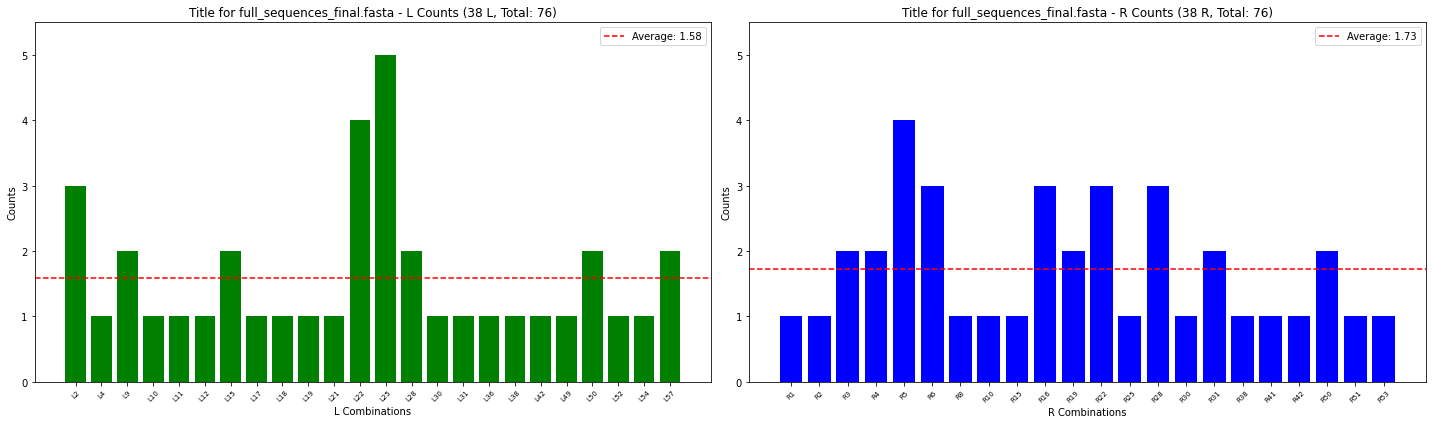

In [3]:
results_directory = "/home/hubert/TRS-omix_new/python/viruses_results_L100_R100_c0.8"
fasta_files_for_plotting = FileHandler.search_for_files(results_directory,'*.fasta')
fasta_files_for_plotting_names = FileHandler.extract_file_names(fasta_files_for_plotting)
print(f"Following fasta files were found in {results_directory} : {fasta_files_for_plotting_names}")
statistics = Stats()
for fasta_path in fasta_files_for_plotting:
    statistics.count_L_R(fasta_path)
file_paths = [file_path for file_path in fasta_files_for_plotting if file_path in statistics.file_info]
names_to_filter = ["full_sequences_final.fasta"]
file_paths = [file_path for file_path in file_paths if os.path.basename(file_path) in names_to_filter]
print(f"{file_paths}")
# Dictionary to store titles for each file path
file_titles = {}

# Populate file_titles dictionary using file_paths list
for file_path in file_paths:
# Extract file name from file path
    file_name = os.path.basename(file_path)

# Construct default title based on file name
default_title = f"Title for {file_name}"

# Add entry to file_titles dictionary
file_titles[file_path] = default_title

statistics.plot_lr_counts(file_paths=file_paths,file_titles=file_titles,results_directory=results_directory)